In [1]:
using Pkg; Pkg.activate(".")
using HypergraphModularity

# using Optim 
using Plots
using TimerOutputs
using StatsBase

 Activating environment at `~/hypergraph_modularities_code/Project.toml`


In [2]:
α0 = vcat([0.0, 0.0, 10.0], [0.0, 5.0, 0.0])
kmax = 3
n = 200
ϑ = repeat([1.0], n);

# all-or-nothing cut with dyadic edges always between group
function Ω(z; α, mode = "group")
    
    p = (mode == "group") ? partitionize(z) : z
    
    k = sum(p)
    
    if length(p) == 1
        return α[k]/n^(k-1)
    elseif length(p) == 2
        return α[kmax+k]/n^(k-1)
    else
        return α[kmax+k]/n^(k)
    end
end

Ω (generic function with 1 method)

In [20]:
function percent_identified(Z, Ẑ)
    d = Dict()
    for i = 1:length(Z)
        d[(Z[i], Ẑ[i])] = get(d, (Z[i], Ẑ[i]), 0) + 1
    end
    if length(unique(Ẑ)) > 1
        return 2*maximum(values(d)) / length(Z)
    else
        return 0
    end
end

percent_identified (generic function with 1 method)

In [60]:
kmax = 3

weighted = false

A = 0.0:1.0:30

C = zero(A)
P = zero(A)

for i in 1:length(A)
    a = A[i]
    Z = vcat(repeat([1], n÷2), repeat([2], n÷2))
    α0 = vcat([0.0, 0.0, a], [0.0, 5.0, 0.0])
    H = sampleSBM(Z, ϑ, Ω;α=α0, kmax=kmax, kmin = 1)
    H.E[1] = Dict()
        
    cᵢ = sum(values(H.E[3]))*3/n
    cₒ = sum(values(H.E[2]))*1/n

    C[i] = (cᵢ - cₒ)/sqrt(2*(cᵢ + cₒ))
    
    Z_ = copy(Z)
    
    n_reps = 10
    
    best_L = -Inf
    best_identified = 0
    
    for i in 1:n_reps
        γ̂ = computeDyadicResolutionParameter(H, Z_)
        Z_ = CliqueExpansionModularity(H, γ̂, weighted, true)
        ω_in, ω_out = computeDyadicResolutionParameter(H, Z_; mode="ω", weighted=weighted)
        L_D = dyadicLogLikelihood(H, Z_, ω_in, ω_out, weighted=weighted)
        
        if L_D > best_L
            best_L = L_D
            best_identified = percent_identified(Z, Z_)
        end
    end
    P[i] = best_identified
end

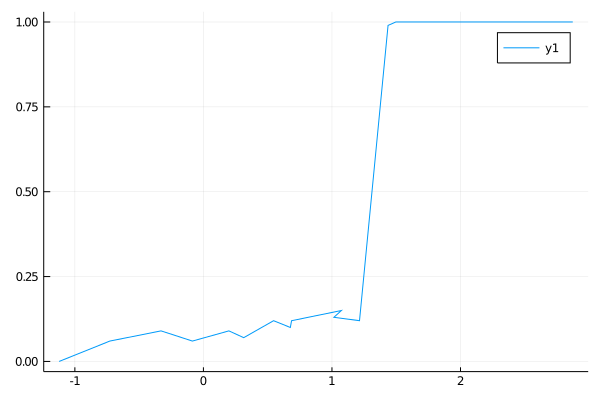

In [61]:
plot(C, P)

In [62]:
kmax = 3

weighted = false

A = 0:1.0:30

C_ = zero(A)
P_ = zero(A)

for i in 1:length(A)
    a = A[i]
    Z = vcat(repeat([1], n÷2), repeat([2], n÷2))
    α0 = vcat([0.0, 0.0, a], [0.0, 5.0, 0.0])
    H = sampleSBM(Z, ϑ, Ω;α=α0, kmax=kmax, kmin = 1)
    H.E[1] = Dict()
        
    cᵢ = sum(values(H.E[3]))*3/n
    cₒ = sum(values(H.E[2]))*1/n

    C_[i] = (cᵢ - cₒ)/sqrt(2*(cᵢ + cₒ))
    
    Z_ = copy(Z)
    α̂ = α0
    
    best_L = -Inf
    best_identified = 0
    
    n_reps = 10
    
    for i in 1:n_reps
        α̂ = coordinateAscent(H, Z_, Ω, α̂; n_iters = 10, amin = 10^(-10), amax = 10)
        Z_ = SuperNodeLouvain(H,kmax,Ω;α=α̂, verbose=false, scan_order ="random")
        L_H = modularity(H, Z_, Ω; α = α̂)
        
        if L_H > best_L
            best_L = L_H
            best_identified = percent_identified(Z, Z_)
        end
    end
    P_[i] = best_identified
end

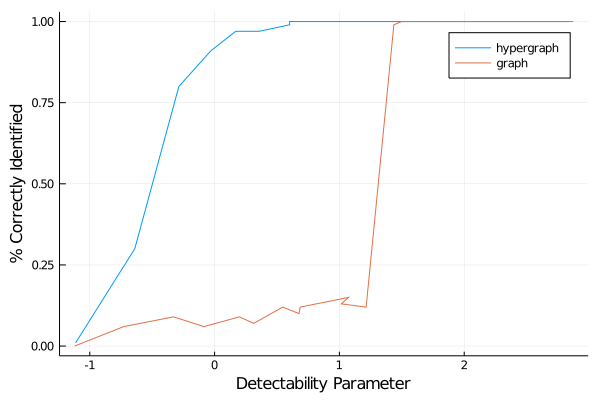

In [63]:
plot(C_, P_, label = "hypergraph")
plot!(C, P, label = "graph")

xlabel!("Detectability Parameter")
ylabel!("% Correctly Identified")

# TODO

Make a nicer plot via ggplot, check in on the location of the phase transition. 